# Imports

In [1]:
import os
print(os.listdir("../input"))

!git clone https://github.com/mebn/ultralytics.git
!cd ultralytics && git pull && cd ..

import torch
import torchvision
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models.feature_extraction import create_feature_extractor
import cv2
import matplotlib.pyplot as plt

import sys
sys.path.append("/kaggle/working/ultralytics")
from ultralytics import YOLO

['seadronessee-yolo-500']
Cloning into 'ultralytics'...
remote: Enumerating objects: 36449, done.
remote: Total 36449 (delta 0), reused 0 (delta 0), pack-reused 36449 (from 1)
Receiving objects: 100% (36449/36449), 22.19 MiB | 20.11 MiB/s, done.
Resolving deltas: 100% (26319/26319), done.
Already up to date.
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Replacing backbone and initialization

In [17]:
model_file = "/kaggle/working/model.yaml"


with open(model_file, "w") as f:
    f.write("""
nc: 80  # number of classes

scales:
  n: [1, 1, 1024]  # actual architecture below is scaled to match n: [0.5, 0.25, 1024]

backbone:
  - [-1, 1, TorchVision, [192, shufflenet_v2_x0_5, DEFAULT, True, 2, True]] # 0

head:
  - [0, 1, Index, [48, 5]]           # 1: P3 raw (stride 8)
  - [0, 1, Index, [96, 6]]           # 2: P4 raw (stride 16)
  - [0, 1, Index, [192, 7]]         # 3: P5 raw (stride 32)

  # Project to scaled YOLOv11 channel sizes (256 → 64, 512 → 128, 1024 → 256)
  - [1, 1, Conv, [64, 1, 1]]         # 4: P3 → 64
  - [2, 1, Conv, [128, 1, 1]]        # 5: P4 → 128
  - [3, 1, Conv, [256, 1, 1]]        # 6: P5 → 256

  # FPN: P5 → P4
  - [6, 1, nn.Upsample, [None, 2, "nearest"]]  # 7
  - [[7, 5], 1, Concat, [1]]                   # 8
  - [-1, 1, C3k2, [128, False]]                # 9 (2 → 1 repeat, 512 → 128)

  # FPN: P4 → P3
  - [9, 1, nn.Upsample, [None, 2, "nearest"]]  # 10
  - [[10, 4], 1, Concat, [1]]                  # 11
  - [-1, 1, C3k2, [64, False]]                 # 12 (256 → 64)

  # PAN: P3 → P4
  - [12, 1, Conv, [64, 3, 2]]                  # 13
  - [[13, 9], 1, Concat, [1]]                  # 14
  - [-1, 1, C3k2, [128, False]]                # 15

  # PAN: P4 → P5
  - [15, 1, Conv, [128, 3, 2]]                 # 16
  - [[16, 6], 1, Concat, [1]]                  # 17
  - [-1, 1, C3k2, [256, True]]                 # 18

  # Final detection layers
  - [[12, 15, 18], 1, Detect, [nc]]            # 19
  

  
# backbone layers:
# 0 torch.Size([1, 3, 640, 640])
# 1 torch.Size([1, 24, 320, 320])
# 2 torch.Size([1, 24, 320, 320])
# 3 torch.Size([1, 24, 320, 320])
# 4 torch.Size([1, 24, 160, 160])
# 5 torch.Size([1, 48, 80, 80])
# 6 torch.Size([1, 96, 40, 40])
# 7 torch.Size([1, 192, 20, 20])
""")


model = YOLO(model_file, task="detect")

# img = torch.randn(1, 3, 640, 640)
# output = model.model(img)
# for o in output:
#     print(o.shape)

WARNING ⚠️ no model scale passed. Assuming scale='n'.


# Data

In [18]:
data_file = "/kaggle/working/data.yaml"


with open(data_file, "w") as f:
    f.write("""train: /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train
val: /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/val
test: /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/test
nc: 1
names: ["human"]""")

# Fine-tuning

In [19]:
model.train(
    data=data_file,
    epochs=300,
    patience=15,
    imgsz=640,
    batch=16,
    name="model"
)

New https://pypi.org/project/ultralytics/8.3.114 available 😃 Update with 'pip install -U ultralytics'
WARNING ⚠️ 'name=model' automatically updated to 'name=/kaggle/working/model'.
Ultralytics 8.3.103 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/model.yaml, data=/kaggle/working/data.yaml, epochs=300, time=None, patience=15, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=model, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=Fals

100%|██████████| 755k/755k [00:00<00:00, 3.72MB/s]
E0000 00:00:1745408362.760939      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745408362.809769      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Overriding model.yaml nc=80 with nc=1
WARNING ⚠️ no model scale passed. Assuming scale='n'.

                   from  n    params  module                                       arguments                     
  0                  -1  1    143136  ultralytics.nn.modules.block.TorchVision     ['shufflenet_v2_x0_5', 'DEFAULT', True, 2, True]
  1                   0  1         0  ultralytics.nn.modules.conv.Index            [5]                           
  2                   0  1         0  ultralytics.nn.modules.conv.Index            [6]                           
  3                   0  1         0  ultralytics.nn.modules.conv.Index            [7]                           
  4                   1  1      3200  ultralytics.nn.modules.conv.Conv             [48, 64, 1, 1]                
  5                   2  1     12544  ultralytics.nn.modules.conv.Conv             [96, 128, 1, 1]               
  6                   3  1     49664  ultralytics.nn.modules.conv.Conv             [192, 25

100%|██████████| 5.35M/5.35M [00:00<00:00, 16.1MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels/train... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:02<00:00, 179.04it/s]

train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train/9563.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train/9565.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train/9569.jpg: 1 duplicate labels removed
train: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels is not writeable, cache not saved.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels/val... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:01<00:00, 164.92it/s]

val: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/val/9560.jpg: 1 duplicate labels removed
val: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels is not writeable, cache not saved.


WARNING ⚠️ 'name=model' automatically updated to 'name=/kaggle/working/model'.
Plotting labels to /kaggle/working/model/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 99 weight(decay=0.0), 106 weight(decay=0.0005), 105 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/model
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      2.06G      3.276      93.37      3.008         27        640: 100%|██████████| 32/32 [00:13<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.29it/s]


                   all        200       1017          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300      2.51G      4.512      33.09      3.137         52        640: 100%|██████████| 32/32 [00:12<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.04it/s]

                   all        200       1017          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      2.51G      3.991      5.699      1.868         26        640: 100%|██████████| 32/32 [00:13<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]

                   all        200       1017    0.00408      0.207     0.0279    0.00538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300      2.51G      3.611      3.742      1.477         27        640: 100%|██████████| 32/32 [00:11<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


                   all        200       1017      0.122      0.119     0.0309    0.00544

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      2.51G      3.412      3.147      1.346         50        640: 100%|██████████| 32/32 [00:10<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.09it/s]

                   all        200       1017      0.146      0.155     0.0572      0.011



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      2.51G      3.345      2.796      1.268         30        640: 100%|██████████| 32/32 [00:11<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.96it/s]

                   all        200       1017      0.378      0.246       0.17     0.0337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      2.51G      3.129      2.546      1.268         39        640: 100%|██████████| 32/32 [00:11<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.65it/s]

                   all        200       1017      0.312      0.269      0.159     0.0372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300      2.51G      3.104      2.365      1.218         39        640: 100%|██████████| 32/32 [00:11<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.52it/s]

                   all        200       1017      0.355      0.298      0.211     0.0449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      2.51G      3.084       2.31      1.263         21        640: 100%|██████████| 32/32 [00:11<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]


                   all        200       1017      0.373      0.279      0.181     0.0393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      2.51G      2.984      2.106      1.229         48        640: 100%|██████████| 32/32 [00:12<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.35it/s]

                   all        200       1017      0.399        0.3      0.213     0.0491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300      2.52G      3.042      2.114      1.165         14        640: 100%|██████████| 32/32 [00:11<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.19it/s]

                   all        200       1017      0.376      0.313      0.215     0.0522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300      2.52G      2.945      2.089      1.177         18        640: 100%|██████████| 32/32 [00:12<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.89it/s]

                   all        200       1017      0.471      0.355      0.297     0.0728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      2.52G      2.916      2.048      1.193         16        640: 100%|██████████| 32/32 [00:12<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.35it/s]

                   all        200       1017      0.461      0.347      0.275     0.0642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      2.52G      2.883      1.969       1.12         23        640: 100%|██████████| 32/32 [00:11<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.18it/s]

                   all        200       1017      0.389      0.334      0.251      0.058



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      2.52G      2.902      1.871      1.132         37        640: 100%|██████████| 32/32 [00:12<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.27it/s]

                   all        200       1017      0.504       0.35        0.3     0.0794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      2.52G      2.857      1.831      1.142         46        640: 100%|██████████| 32/32 [00:11<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]


                   all        200       1017      0.446      0.313      0.262     0.0651

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      2.52G      2.816      1.732      1.124         38        640: 100%|██████████| 32/32 [00:11<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.16it/s]

                   all        200       1017      0.492      0.376       0.33     0.0884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      2.52G      2.834       1.73      1.164         33        640: 100%|██████████| 32/32 [00:11<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.70it/s]

                   all        200       1017      0.448      0.342      0.283      0.071



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      2.52G       2.81      1.691      1.119         49        640: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.83it/s]

                   all        200       1017      0.419       0.35      0.277     0.0692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      2.52G      2.782       1.65      1.113         23        640: 100%|██████████| 32/32 [00:11<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.22it/s]

                   all        200       1017      0.485      0.347      0.305     0.0807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      2.52G       2.81      1.638      1.176         20        640: 100%|██████████| 32/32 [00:11<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        200       1017      0.469      0.362       0.29     0.0747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      2.52G      2.738      1.581      1.111         20        640: 100%|██████████| 32/32 [00:12<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.29it/s]

                   all        200       1017      0.448      0.353      0.297     0.0783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      2.52G      2.779      1.566      1.103         21        640: 100%|██████████| 32/32 [00:12<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.32it/s]

                   all        200       1017      0.429      0.367      0.303     0.0804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      2.52G      2.734      1.549      1.109         29        640: 100%|██████████| 32/32 [00:12<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.68it/s]

                   all        200       1017      0.494      0.386      0.329     0.0972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      2.52G       2.68      1.499      1.108         28        640: 100%|██████████| 32/32 [00:11<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.25it/s]

                   all        200       1017      0.528      0.374      0.343     0.0889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      2.52G      2.671      1.501      1.123         26        640: 100%|██████████| 32/32 [00:11<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        200       1017      0.534      0.408      0.361     0.0996



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300      2.52G      2.728      1.514      1.082         47        640: 100%|██████████| 32/32 [00:11<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.10it/s]

                   all        200       1017      0.507      0.358      0.299     0.0795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      2.52G      2.702      1.485      1.105         32        640: 100%|██████████| 32/32 [00:11<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]

                   all        200       1017      0.482      0.356      0.324     0.0872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      2.52G      2.719      1.469      1.105         21        640: 100%|██████████| 32/32 [00:11<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.05it/s]

                   all        200       1017      0.434      0.369      0.313     0.0874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      2.52G      2.646      1.425      1.075         26        640: 100%|██████████| 32/32 [00:11<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.79it/s]

                   all        200       1017      0.474      0.382      0.331     0.0875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300      2.52G      2.686      1.487       1.16         24        640: 100%|██████████| 32/32 [00:12<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.57it/s]

                   all        200       1017      0.479      0.375       0.31     0.0852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      2.52G      2.583      1.372      1.098         42        640: 100%|██████████| 32/32 [00:11<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.44it/s]

                   all        200       1017      0.526      0.379      0.344      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      2.52G      2.722      1.441      1.146         36        640: 100%|██████████| 32/32 [00:13<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        200       1017      0.528      0.353      0.303     0.0825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      2.52G      2.596      1.341      1.082         37        640: 100%|██████████| 32/32 [00:11<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        200       1017      0.491      0.386       0.35     0.0983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300      2.52G       2.63       1.33      1.102         29        640: 100%|██████████| 32/32 [00:12<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.18it/s]

                   all        200       1017      0.519      0.381      0.368      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      2.52G      2.707      1.346      1.078         32        640: 100%|██████████| 32/32 [00:12<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.63it/s]

                   all        200       1017      0.495      0.369      0.313     0.0779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300      2.52G      2.693      1.409      1.104         25        640: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.68it/s]

                   all        200       1017      0.462      0.364      0.341     0.0916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300      2.52G      2.601      1.377      1.067         41        640: 100%|██████████| 32/32 [00:11<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        200       1017      0.484       0.38      0.343     0.0986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      2.52G      2.569       1.31      1.062         25        640: 100%|██████████| 32/32 [00:12<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.24it/s]

                   all        200       1017      0.546      0.398       0.39       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      2.52G      2.566      1.336      1.108         28        640: 100%|██████████| 32/32 [00:13<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.23it/s]

                   all        200       1017      0.512      0.405      0.373      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300      2.52G      2.607      1.326      1.086         47        640: 100%|██████████| 32/32 [00:12<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.18it/s]

                   all        200       1017      0.539      0.401       0.39      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      2.52G      2.501       1.26       1.11         30        640: 100%|██████████| 32/32 [00:12<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.07it/s]

                   all        200       1017      0.541      0.405      0.382      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300      2.52G      2.631      1.288      1.059         22        640: 100%|██████████| 32/32 [00:12<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        200       1017      0.496      0.381      0.342     0.0963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      2.52G       2.56      1.318      1.118         32        640: 100%|██████████| 32/32 [00:13<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.52it/s]

                   all        200       1017      0.539      0.387      0.378       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300      2.52G      2.507       1.26      1.043         41        640: 100%|██████████| 32/32 [00:12<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.70it/s]

                   all        200       1017      0.508      0.379      0.352      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300      2.52G      2.514      1.245      1.063         36        640: 100%|██████████| 32/32 [00:12<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

                   all        200       1017      0.521      0.401      0.385      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      2.52G      2.486      1.239      1.051         30        640: 100%|██████████| 32/32 [00:11<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.33it/s]

                   all        200       1017      0.536      0.388      0.374      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      2.52G      2.512      1.218      1.026         40        640: 100%|██████████| 32/32 [00:11<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.21it/s]

                   all        200       1017      0.534      0.393      0.355     0.0981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300      2.52G      2.503      1.263      1.057         38        640: 100%|██████████| 32/32 [00:12<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]

                   all        200       1017      0.533      0.417      0.382      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300      2.52G      2.537      1.245       1.06         56        640: 100%|██████████| 32/32 [00:11<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]

                   all        200       1017      0.559       0.39      0.379      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300      2.52G      2.465      1.194      1.047         36        640: 100%|██████████| 32/32 [00:12<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.14it/s]

                   all        200       1017      0.521      0.395      0.375      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300      2.52G      2.509      1.235      1.062         27        640: 100%|██████████| 32/32 [00:12<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]

                   all        200       1017      0.497      0.387      0.364      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300      2.52G      2.513      1.224      1.025         57        640: 100%|██████████| 32/32 [00:12<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.79it/s]

                   all        200       1017      0.488      0.423      0.398      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300      2.52G      2.422      1.191       1.07         33        640: 100%|██████████| 32/32 [00:12<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.17it/s]

                   all        200       1017      0.568      0.423      0.427       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300      2.52G      2.413      1.187        1.1         21        640: 100%|██████████| 32/32 [00:13<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.31it/s]

                   all        200       1017      0.523      0.376      0.335     0.0989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300      2.52G      2.483      1.189      1.042         44        640: 100%|██████████| 32/32 [00:12<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]

                   all        200       1017      0.557      0.413      0.403      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300      2.52G      2.458      1.221      1.026         11        640: 100%|██████████| 32/32 [00:13<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.56it/s]

                   all        200       1017      0.513      0.408      0.389      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300      2.52G      2.488      1.198      1.059         36        640: 100%|██████████| 32/32 [00:12<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.41it/s]

                   all        200       1017      0.547      0.433      0.395      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300      2.52G       2.37      1.153      1.056         38        640: 100%|██████████| 32/32 [00:12<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.80it/s]

                   all        200       1017      0.521      0.391      0.374      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300      2.52G      2.428      1.153      1.058         51        640: 100%|██████████| 32/32 [00:11<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.33it/s]

                   all        200       1017       0.51      0.399      0.384      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300      2.52G      2.439      1.163      1.019         43        640: 100%|██████████| 32/32 [00:12<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.61it/s]

                   all        200       1017      0.555      0.429        0.4       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300      2.52G      2.341      1.149       1.06         21        640: 100%|██████████| 32/32 [00:11<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.99it/s]

                   all        200       1017       0.56       0.42      0.391      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300      2.52G      2.482        1.2      1.042         45        640: 100%|██████████| 32/32 [00:12<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        200       1017      0.589      0.399      0.406       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300      2.52G      2.456      1.197      1.051         27        640: 100%|██████████| 32/32 [00:12<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.21it/s]

                   all        200       1017      0.517      0.376      0.346      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300      2.52G       2.39       1.17      1.048         38        640: 100%|██████████| 32/32 [00:11<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]

                   all        200       1017       0.54      0.416      0.385      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300      2.52G       2.41      1.142      1.018         29        640: 100%|██████████| 32/32 [00:12<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.79it/s]

                   all        200       1017      0.576       0.43      0.414      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300      2.52G      2.392      1.161      1.032         31        640: 100%|██████████| 32/32 [00:11<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.57it/s]

                   all        200       1017      0.536      0.392      0.398      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300      2.52G      2.407      1.129      1.043         30        640: 100%|██████████| 32/32 [00:13<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        200       1017      0.543      0.429      0.416      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300      2.52G      2.377      1.154      1.032         13        640: 100%|██████████| 32/32 [00:12<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.52it/s]

                   all        200       1017       0.54      0.442      0.419       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300      2.52G       2.43      1.195      1.016         23        640: 100%|██████████| 32/32 [00:12<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]

                   all        200       1017      0.585      0.452      0.438      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300      2.52G        2.4       1.15      1.036         51        640: 100%|██████████| 32/32 [00:12<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]

                   all        200       1017      0.601      0.437      0.427      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300      2.52G      2.349      1.112      1.035         20        640: 100%|██████████| 32/32 [00:13<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.52it/s]

                   all        200       1017      0.617      0.448       0.44      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300      2.52G      2.432      1.149      1.036         46        640: 100%|██████████| 32/32 [00:12<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]

                   all        200       1017      0.588      0.424      0.399      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300      2.52G        2.3      1.107      1.052         44        640: 100%|██████████| 32/32 [00:11<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.03it/s]

                   all        200       1017      0.566      0.436      0.428      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300      2.52G      2.346      1.091       1.02         28        640: 100%|██████████| 32/32 [00:12<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        200       1017      0.564      0.418      0.415       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300      2.52G      2.346      1.114      1.034         45        640: 100%|██████████| 32/32 [00:13<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.05it/s]

                   all        200       1017      0.564      0.419      0.421      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      2.52G      2.388       1.14      1.042         19        640: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.31it/s]

                   all        200       1017      0.562      0.418      0.423      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300      2.52G      2.348      1.114      1.086         33        640: 100%|██████████| 32/32 [00:12<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.09it/s]

                   all        200       1017      0.597      0.435      0.418      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300      2.52G      2.342       1.11      1.044         31        640: 100%|██████████| 32/32 [00:12<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.25it/s]

                   all        200       1017      0.558      0.456      0.435       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300      2.52G      2.357      1.096      1.012         24        640: 100%|██████████| 32/32 [00:12<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.57it/s]

                   all        200       1017      0.646       0.45      0.467      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300      2.52G      2.265      1.083      1.051         25        640: 100%|██████████| 32/32 [00:12<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.86it/s]

                   all        200       1017      0.574      0.411       0.41      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300      2.52G      2.283      1.071      1.018         51        640: 100%|██████████| 32/32 [00:12<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.79it/s]

                   all        200       1017      0.581      0.434      0.419      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300      2.52G      2.335      1.136      1.014         40        640: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.78it/s]

                   all        200       1017      0.621      0.441      0.437      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300      2.52G      2.315      1.091      1.012         48        640: 100%|██████████| 32/32 [00:11<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.50it/s]

                   all        200       1017      0.647      0.437      0.448      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300      2.52G       2.32      1.116      1.035         56        640: 100%|██████████| 32/32 [00:12<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.02it/s]

                   all        200       1017      0.594      0.452      0.448      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/300      2.52G      2.305      1.081      1.017         43        640: 100%|██████████| 32/32 [00:11<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.77it/s]

                   all        200       1017      0.573      0.431      0.417      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/300      2.52G      2.289      1.089      1.024         41        640: 100%|██████████| 32/32 [00:12<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.97it/s]

                   all        200       1017      0.492      0.393       0.36      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/300      2.52G      2.291      1.094      1.032         22        640: 100%|██████████| 32/32 [00:12<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.77it/s]

                   all        200       1017       0.58      0.441      0.424      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/300      2.52G        2.3      1.102      1.039         60        640: 100%|██████████| 32/32 [00:12<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        200       1017      0.554      0.445      0.419      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/300      2.52G       2.27      1.057      1.008         53        640: 100%|██████████| 32/32 [00:11<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]

                   all        200       1017      0.628      0.434      0.437      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/300      2.52G      2.336      1.081     0.9868         25        640: 100%|██████████| 32/32 [00:11<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        200       1017      0.567      0.431      0.422      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/300      2.52G      2.273      1.057      1.002         41        640: 100%|██████████| 32/32 [00:13<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        200       1017      0.574      0.431       0.42      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/300      2.52G      2.264      1.061      0.973         48        640: 100%|██████████| 32/32 [00:11<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


                   all        200       1017      0.572       0.45      0.439      0.144

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/300      2.52G      2.241      1.028      0.995         42        640: 100%|██████████| 32/32 [00:13<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.59it/s]

                   all        200       1017      0.599      0.447      0.432       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/300      2.52G      2.293      1.074      1.019         16        640: 100%|██████████| 32/32 [00:12<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]

                   all        200       1017       0.58      0.428      0.416      0.126
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 80, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



95 epochs completed in 0.391 hours.
Optimizer stripped from /kaggle/working/model/weights/last.pt, 3.2MB
Optimizer stripped from /kaggle/working/model/weights/best.pt, 3.2MB

Validating /kaggle/working/model/weights/best.pt...
Ultralytics 8.3.103 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
model summary: 221 layers, 1,425,059 parameters, 0 gradients


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


                   all        200       1017      0.644      0.449      0.468      0.143


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.3ms preprocess, 2.5ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to /kaggle/working/model


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f1ec9ee56d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# Testing

In [20]:
def show_img_with_boxes(res):
    img = res[0].plot()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


image 1/1 /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/test/10209.jpg: 384x640 1 human, 49.8ms
Speed: 2.3ms preprocess, 49.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


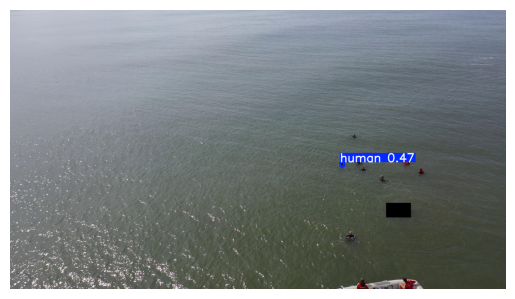

Ultralytics 8.3.103 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
model summary: 221 layers, 1,425,059 parameters, 0 gradients


val: Scanning /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels/test... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:01<00:00, 167.30it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.50it/s]


                   all        200       1072      0.633      0.522      0.507      0.165


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 1.3ms preprocess, 3.3ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /kaggle/working/ultralytics/runs/detect/val


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f1ea2bac050>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [21]:
model = YOLO("/kaggle/working/model/weights/best.pt")

img = "/kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/test/10209.jpg"

results = model(img)
show_img_with_boxes(results)

model.val(
    data=data_file,
    split="test"
)